# Rock Coast Modelling Lab
Geomorphic systems tend to develop slowly relative to the timescale of a human life. One way in which we can understand how landscapes change over longer timescales is to use computer models to simulate geomorphic processes. In this lab you will apply a simple model for how rock coasts develop over time. The model is referred to as "simple" because it relies on mathematical simplifications, and rules, to represent otherwise complex physics in an abstracted way. The advantage of such an approach is that we can change individual components (such as tidal range) and explore how it influences the development of rock coast morphology.

The model developed here is based on the work of Sunamura (1992), Trenahile (2000), Hurst et al. (2017), and Matsumoto et al. (2016), but has been kept to the basic critical components for the purposes of this lab. 

The model is written in the Python computer programming language, but you don't need any prior knowledge of computer programming. The aims of this lab are
* Understand how coastal processes can be represented numerically
* Run the numerical model to simulate shore platform development
* Explore the controls on how rapidly rock coasts evolve through time
* Create and explain graphs/figures that demonstrate particular controls on shore platform morphology

### Python
The programming language we are using in this lab is called Python. No prior knowledge of programming is required for this lab. Learning how to be a programmer is not the aim! However, this sort of scientific computing is becoming more common place in research and consultancy, so it won't do you any harm to see it in action. Python is multifunctional, for example it can interface with QGIS (software we will use un future labs) to automate workflows.

This notebook file is split into blocks of text and blocks of code. **To run a code block, click in a cell, hold down shift, and press enter.** An asterisk in square brackets `In [*]:` will appear while the code is being executed, and this will change to a number `In [1]:` when the code is finished. *The order in which you execute the code blocks matters, they must be run in sequence.* If you run into any errors, click the "Kernel" menu at the of the page and then "Restart & Clear Output" and then run everything again from the top. 

Inside blocks of python code there are comments indicated by lines that start with `#`. These lines are not computer code but rather comments providing information about what the code is doing to help you follow along. 

Before we get started we need to tell python which tools we want to use (these are called modules):

In [3]:
# import modules <- this is a comment
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# tell python to allow plotting to occur within the page
%matplotlib inline

# Customise figure style
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
rc('font', size=16)

# Couple of other things for displaying model progress
from ipywidgets import FloatProgress
from IPython.display import display

## Model Framework

A numerical model of a rock coast needs to take our perception of how rock coasts develop and identify they key processes that need to be represented. The schematic diagram from the lecture (after Castedo et al., 2017) can show the key componeents of the system we need to represent using a computer.

<img src="schematic_rock_coast.png" width="800">

For modelling purposes we will consider the rock coast in cross section only as per the grey schematic on the left. The topography is then represented as a horizontal stack of bars of rock as per the right hand image. The model coast then evolves by keeping track of the horizontal position of each bar. We decide whether or not to erode each bar by considering the balance of driving forces (i.e. wave force) vs. resisting force (rock mass strength) as the model evolves through time. The modelling process we will follow is set out in the following diagram from Matsumoto et al. (2016):

<img src="model_flow_diagram.png" width="800">

Before we attempt to model how a rock coast evolves, we're first going to explore some of the individual components that go into the model, so that you can see how these are represented simply using mathematics and implemented in a computer programme. ***There are exercises highlighted in blue boxes for you to complete as you work through this interactive notebook***, these include being asked to modify certain parts of the computer code to change the values of key parameters. The locations you should modify have been highlighted clearly in the style shown in the box below.

In [4]:
""" THIS IS AN EXAMPLE OF SOMETHING YOU SHOULD MODIFY"""
MYPARAMETER = 10.

## Waves
Whether or not erosion takes place depends on the balance of wave force to resisting force. So we'll start by exploring how we can represent wave force using a computer. We could devote an entire course to the physics of waves, but for the purposes of this session we will explore some simplified ideas about how ocean waves change as they approach the coast. The transformation of waves as they approach the shore dictates where, and how much wave energy is available to do geomorphic work; transporting sediment, plucking blocks of bedrock from the shore platform, or impacting against shore platforms and cliffs.

To think about how waves interact with the coast, we'll start by setting up a basic nearshore topography, a planar sloping surface or platform:

Text(0, 0.5, 'Elevation (m)')

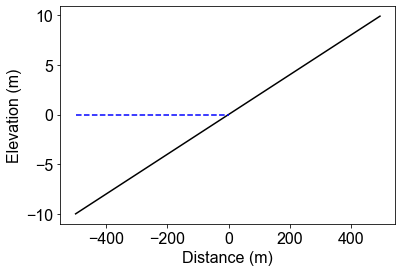

In [5]:
""" SET THE SLOPE OF THE PLATFORM HERE """
SLOPE = 0.02

# set up the geometry wher Z is elevation and X is cross-shore distance
Z = np.arange(-10.,10.,0.1)
X = Z/SLOPE

# find sea level
SLInd = np.argmin(np.abs(0.-Z))

# set up a figure and set of axes for plotting
fig1, ax1 = plt.subplots()

# plot the platform and mean sea level at 0m
ax1.plot(X,Z,'k-')
ax1.plot([X[0],X[SLInd]],[0,0],'b--')
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Elevation (m)")

# set no vertical exaggeration on the plot
# ax1.axis('equal')
# ax1.set_aspect(10.)

### Wave Breaking
An empirical rule of thumb is that waves begin to break when they reach a water depth that is 80% of the wave height. So let's calculate water depth and find the location at which a wave breaks for a particular wave height:

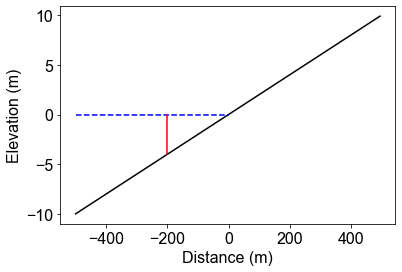

In [6]:
""" SET THE WAVE HEIGHT HERE """
WAVEHEIGHT = 5.

# calculate water depth and find breaking point
WaterDepth = 0-Z[0:SLInd]
BreakingPoint = np.argmin(np.abs(WaterDepth-WAVEHEIGHT*0.8))

#plot the breaking point
ax1.plot([X[BreakingPoint],X[BreakingPoint]],[-WaterDepth[BreakingPoint],0],'r-')
fig1

### The decay of breaking wave height
Once waves begin to break, wave height decreases. This decrease can be approximated by an exponential function where the height of the breaking wave as it progresses shoreward $H_b$ depends on the wave height offshore before it breaks $H_0$, the distance the wave has travelled since breaking $x_b$ and a decay coefficient that describes how rapidly the breaking wave loses height (and energy) $k$:

$$
\begin{equation}
H_b = H_0 e^{-k x_b}
\end{equation}
$$

Appropriate values for the decay coefficient are somewhere in the region 0.01 to 1. Let's make a plot of how wave height changes after a wave breaks as it moves towards the shore:

(-210.00000000000105, 9.999999999998224)

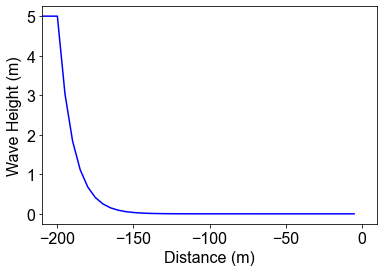

In [7]:
""" SET THE WAVE DECAY COEFFICIENT HERE
    AND THE COLOUR OF THE LINE TO PLOT """
DECAY_COEFFICIENT = 0.1
COLOUR = 'b' #blue

# calculate wave heights
H = np.zeros(SLInd)
H[0:BreakingPoint] = WAVEHEIGHT
H[BreakingPoint:] = WAVEHEIGHT*np.exp(-(X[BreakingPoint:SLInd]-X[BreakingPoint])*DECAY_COEFFICIENT)

# set up a figure and set of axes for plotting
fig2, ax2 = plt.subplots()

ax2.plot(X[0:SLInd],H,'-',color=COLOUR)
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Wave Height (m)")
ax2.set_xlim(X[BreakingPoint]-10.,X[SLInd]+10.)

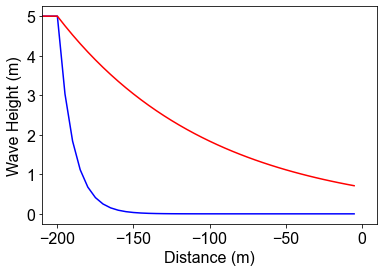

In [8]:
""" SET THE WAVE DECAY COEFFICIENT AGAIN HERE """
DECAY_COEFFICIENT = 0.01

# execute the exponential equation again here for the breaking wave
H[BreakingPoint:] = WAVEHEIGHT*np.exp(-(X[BreakingPoint:SLInd]-X[BreakingPoint])*DECAY_COEFFICIENT)

# plot the new result with a red line
"""
YOU CAN CHANGE THE COLOUR OF THE LINE HERE
"r" = red, "g" = green, "k" = black
or you can use an RedGreenBlue combination
[0,0,0] is black; [0.5,0.5,0.5] is grey
[1,0,1] is purple etc.
"""
COLOUR = "r"
ax2.plot(X[0:SLInd],H,'-',color=COLOUR)

# display the updated figure
fig2


<div class="alert alert-block alert-info">
<font color="black">
<h3>TASK 1</h3>
<p> Modify parameters above to answer the following questions:
<ol>
    <li>Do waves break closer to the coast on gentler or steeper sloping platforms?
    <li>Do large waves tend to break nearer the coast or further offshore?
    <li>Change the value of the wave decay coefficient to explore the range of values from $k = 0.01$ up to $k = 1$. Based on your experience of coasts what do you think a realistic value might be?
</ol>
</p>
<p></p>
</font>
</div>

### DOUBLE CLICK ON THIS BLOCK AND YOU CAN TYPE YOUR ANSWERS

Type your answers here once you have double-clicked.

## Tides

The elevations at which wave energy is delivered to the coast vary with the tides. The greater the tidal range, the wider range of elevations can potentially be attacked by waves and eroded. Just like waves, tides can be represented mathematically using a sinusoidal function to describe the change in mean water surface elevation $z_w$ through time $t$ (hours) over a single tidal cycle:

$$
\begin{equation}
z_w = {{1}\over{2}} T_R \sin \left( {{2\pi t}\over{T_D}} \right)
\end{equation}
$$

where $T_R$ is the tidal range, and $T_D$ is the tidal duration (12 hours for semidiurnal tides for simplicity).

Text(0, 0.5, 'Water level (m)')

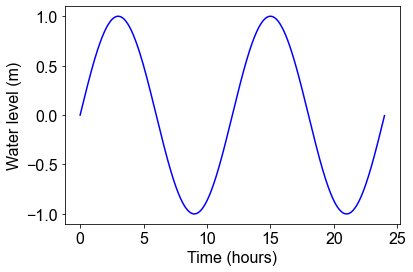

In [9]:
""" SET THE TIDAL RANGE HERE (in metres) """
TIDAL_RANGE = 2.

# set up time vector and apply sine wave to show the tide.
time = np.arange(0,24.,0.01)
Zw = 0.5*TIDAL_RANGE*np.sin(time*2.*np.pi/12.)

# set up a figure and set of axes for plotting
fig3, ax3 = plt.subplots()

# plot a tidal wave over a single day
ax3.plot(time,Zw,'b-')
ax3.set_xlabel("Time (hours)")
ax3.set_ylabel("Water level (m)")

So the tide means that waves can attack a range of elevations, but those elevations do not all recieve the same amount of energy. We can plot a histogram of the water levels the tide operates at in order to visualise this:

Text(0, 0.5, 'Water level (m)')

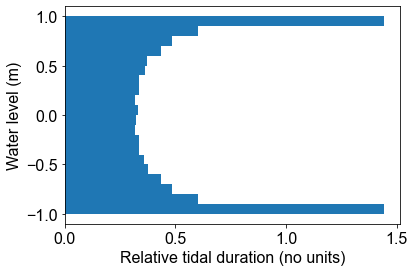

In [10]:
fig4, ax4 = plt.subplots()
ax4.hist(Zw, bins=20, orientation='horizontal', density=True)
ax4.set_xlabel("Relative tidal duration (no units)")
ax4.set_ylabel("Water level (m)")

As you can see, when we split the tidal range up into equal elevation parts, the tide spends more time close to the limits of its range than it does in the elevations in between. So we might expect that erosion will be focused at the upper and lower tidal limit. This would make sense for the formation of type B platforms.

<img src="platform_types.png" width="800">

Now let's look at how that influences where waves break across a shore platform. First, let's check our shore platform defined above is still in place, creating a new figure:

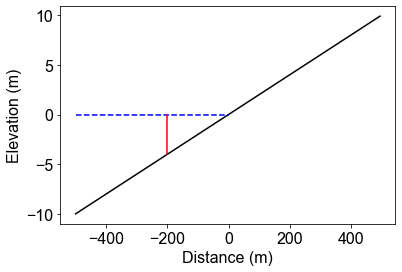

In [11]:
fig1

We will select each value of the water level in turn and find the position of the breaking wave at each elevation and integrate all the breaking wave energy delivered across a single tidal cycle.

(-200.0, 100.0)

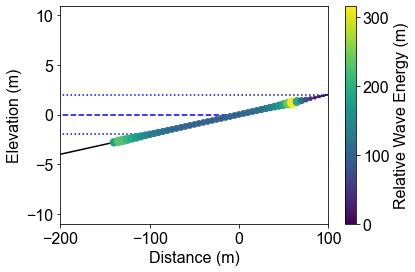

In [12]:
""" SET THE TIDAL RANGE HERE (in metres) """
TIDAL_RANGE = 4.

""" SET THE WAVE HEIGHT AGAIN HERE """
WAVEHEIGHT = 1.

""" SET THE WAVE DECAY COEFFICIENT AGAIN HERE """
DECAY_COEFFICIENT = 0.1

# set up an array to collect wave energy in
CumulativeWaveHeight = np.zeros(len(Z))

# reset water levels incase change of wave height
Zw = 0.5*TIDAL_RANGE*np.sin(time*2.*np.pi/12.)

# set up a loop to consider each water level in the progressive position of the tide in turn
for WaterLevel in Zw:
    
    # find water level
    WaterLevelInd = np.argmin(np.abs(WaterLevel-Z))
    
    # calculate water depth and find breaking point
    WaterDepth = WaterLevel-Z[0:WaterLevelInd]
    BreakingPoint = np.argmin(np.abs(WaterDepth-WAVEHEIGHT*0.8))
    
    # calculate wave height from this point towards the coast
    H = np.zeros(len(Z))
    H[BreakingPoint:] = WAVEHEIGHT*np.exp(-(X[BreakingPoint:]-X[BreakingPoint])*DECAY_COEFFICIENT)
    
    # update the total wave energy array
    CumulativeWaveHeight += H

NormedWaveEnergy = CumulativeWaveHeight/np.max(CumulativeWaveHeight)

# find high and low tide positions
LowTideInd = np.argmin(np.abs(-0.5*TIDAL_RANGE-Z))
HighTideInd = np.argmin(np.abs(0.5*TIDAL_RANGE-Z))

# plot the results
fig5, ax5 = plt.subplots()

# plot the platform and mean sea level at 0m
ax5.plot(X,Z,'k-')
ax5.plot([X[0],X[SLInd]],[0,0],'b--')
ax5.plot([X[0],X[LowTideInd]],[-0.5*TIDAL_RANGE,-0.5*TIDAL_RANGE],'b:')
ax5.plot([X[0],X[HighTideInd]],[0.5*TIDAL_RANGE,0.5*TIDAL_RANGE],'b:')
ax5.set_xlabel("Distance (m)")
ax5.set_ylabel("Elevation (m)")
 
sc = ax5.scatter(X, Z, s=NormedWaveEnergy*100., c=CumulativeWaveHeight, zorder=10)
cbar = plt.colorbar(sc)
cbar.set_label("Relative Wave Energy (m)")

""" MODIFY THE NUMBERS HERE TO CONTROL THE LIMITS OF THE HORIZONTAL AXIS IF YOU WANT TO"""
ax5.set_xlim(-200,100)

<div class="alert alert-block alert-info">
<font color="black">
<h3>TASK 2</h3>
<p> Modify parameters above to answer the following questions:
<ol>
    <li>Where in the intertidal zone is the most wave energy focused? (e.g. upper, middle, lower, relative to mean sea level).
    <li>Does modifying the wave height change where energy is focused in the intertidal zone?
    <li>Does modifying the tidal range change where energy is focused in the intertidal zone?
    <li>Does modifying the wave decay coefficient change where energy is focused at the coast?
</ol>
</p>
<p></p>
</font>
</div>

### DOUBLE CLICK ON THIS BLOCK AND YOU CAN TYPE YOUR ANSWERS

Type your answers here once you have double-clicked.

## Rock decay

There are a number of weathering processes that operate across shore platforms, and the rates of rock weathering and controls upon it are not well studied, in part due to the highly site specific nature and dependence on local bedrock type. Nevertheless, empirical and experimental research has related rates intertidal rock weathering to position within the intertidal zone (Porter et al., 2010). It is hypothesised that there is some optimum period of time for a shore platform to be dry for in order to maximise the efficacy of wetting-drying cycles causing differential stress within the rock, and allowing salt crystal growth to gradually prise open weaknesses. 

<img src="porter_weathering_function.png" width="400">

Whilst ignoring some key processes, such as the role of biological agents, these experiments identified a relationship that can described mathematically using a humped exponential function that sets the peak rock decay efficacy at an elevation halfway between mean sea level and high tide:

$$
\begin{equation}
W_R = W_0 e^{{-(Z_{int}-0.25 T_R)^2}\over{0.025 T_R}} \qquad \textrm{where} \qquad z > Z_W
\end{equation}
$$

$$
\begin{equation}
W_R = W_0 e^{{-(Z_W-Z_{int})^2}\over{0.25 T_R}} \qquad \textrm{where} \qquad z < Z_W
\end{equation}
$$

You dont need to worry too much about the precise nature of these equations, except that they have been manipulated to best describe the distribution of rock decay in the intertidal zone identified by Porter et al. (2010). We can make out own version of this plot by applyign the equations above:

(-2.0, 2.0)

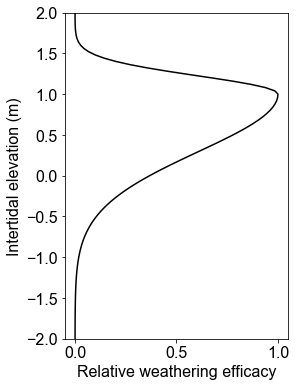

In [13]:
# set up intertidal elevations
IntertidalElevations = np.arange(0.5*TIDAL_RANGE,-0.5*TIDAL_RANGE-0.000001,-TIDAL_RANGE/100.)
WeatheringEfficacy = np.zeros(len(IntertidalElevations))

# find the location of the maximimum weathering rate
MaxWeatheringInd = np.argmin(np.abs(IntertidalElevations-0.25*TIDAL_RANGE))

#calculate the distribution of weathering rates
WeatheringEfficacy[0:MaxWeatheringInd] = np.exp(-((IntertidalElevations[0:MaxWeatheringInd]-0.25*TIDAL_RANGE)**2.)/(0.1*0.25*TIDAL_RANGE))
WeatheringEfficacy[MaxWeatheringInd:] = np.exp(-(0.25*TIDAL_RANGE-IntertidalElevations[MaxWeatheringInd:])**2./(0.25*TIDAL_RANGE))

# set up a new figure
fig6, ax6 = plt.subplots(figsize=(4,6))
ax6.plot(WeatheringEfficacy, IntertidalElevations, 'k-')
ax6.set_xlabel("Relative weathering efficacy")
ax6.set_ylabel("Intertidal elevation (m)")
ax6.set_ylim(-0.5*TIDAL_RANGE,0.5*TIDAL_RANGE)

<div class="alert alert-block alert-info">
<font color="black">
<h3>TASK 3</h3>
<p> Building on your knowledge of where wave energy is focused in the intertidal zone from earlier in the lab, compare to where intertidal weathering processes operate most effectively. What are the implications for the development of shore platforms?
</p>
<p></p>
</font>
</div>

### DOUBLE CLICK ON THIS BLOCK AND YOU CAN TYPE YOUR ANSWERS

Type your answers here once you have double-clicked.

## MODEL

The block of code below brings this theory together and defines the model for shore platform development we will use. You will be guided on how to modify and run the model below this block of code. 

The code below is a class function that ***defines*** the model. This means that we create the model as a set of instruction but doesn't actually execute them or run the model yet. We will ***call*** this class function later once we are ready to run the model. You do not need to spend loads of time fully understanding exactly how the model works, but cast your eyes through it reading the comments to see that the structure reflects the flow diagram above. Then execute the cell containing the model so that it is ***defined***.

In [54]:
# The main model goes here as a python class
class RockCoast:
    
    """ 
    A simple rock coast evolution model for teaching purposes
    
    Martin D. Hurst
    University of Glasgow
    August 2020
        
    """
    
    # setup an initialisation function
    # This defines the default variables and parameters for the model
    def __init__(self):
        
        # default spatial domain
        self.InitialSlope = 1.  # intial conditions
        self.dz = 0.1           # row spacing (metres)
        self.ZMax = 10.          # max elevation (metres)
        self.ZMin = -10.          # min elevation (metres)
        self.Z = np.arange(self.ZMin,self.ZMax,self.dz)
        self.X = self.Z/self.InitialSlope
        
        # default boundary conditions
        self.WaveHeight = 2.        # wave height (metres)
        self.WaveForceCoef = 10.    # coefficient for efficiency of wave action
        self.TidalRange = 2.        # tidal range (metres)
        self.WaveDecayCoef = 0.1    # (in metres?)
        self.SeaLevel = 0.          # elevation (metres)
        self.SeaLevelRise = 0.      # rate (m/yr)
        
        # tectonics
        self.EarthquakeUplift = 0.
        self.EarthquakeTime = 1000.
        self.EarthquakeInterval = 1000.
        
        # resistance and weathering
        self.MaxResistance = 2000.
        self.Resistance = np.ones(len(self.Z))*self.MaxResistance
        self.MaxWeatheringEfficacy = 100.
        
        # setup the time control
        self.Time = 0.         # we will start at time 0 (years)
        self.dt = 1.           # time step (y)
        self.EndTime = 1000.   # time the model will stop (y)
        
        # setup plotting control
        self.PlotFigures = True
        self.PlotTime = 0.
        self.PlotInterval = 100.
            
    # this function runs the model
    def RunModel(self):
        
        # Create a progress bar to show the model is working
        f = FloatProgress(min=self.Time,max=self.EndTime)
        display(f)
        
        # set up a figure for plotting the profile results
        fig1, ax1 = plt.subplots(figsize=(16,6))
        ax1.set_xlabel("Distance (m)")
        ax1.set_ylabel("Elevation (m)")

        # set up a figure for plotting the profile results
        fig2, ax2 = plt.subplots(figsize=(10,6))
        ax2.set_xlabel("Time (years)")
        ax2.set_ylabel("Retreat Rate (m/y)")

        # some lists for plotting
        Times = []
        Rates = []
        
        # reset the initial model domain
        self.Z = np.arange(self.ZMin,self.ZMax,self.dz)
        self.X = self.Z/self.InitialSlope
        
        # set up an array to collect wave energy in
        CumulativeWaveHeight = np.zeros(len(self.Z))

        # create tidal water levels
        TideTime = np.arange(0,24.,0.1)
        Zw = 0.5*self.TidalRange*np.sin(TideTime*2.*np.pi/12.)
        
        # set up weathering distribution
        IntertidalElevations = np.arange(0.5*self.TidalRange,-0.5*self.TidalRange-0.000001,-self.dz)
        WeatheringEfficacy = np.zeros(len(IntertidalElevations))

        # find the location of the maximimum weathering rate
        MaxWeatheringInd = np.argmin(np.abs(IntertidalElevations-0.25*self.TidalRange))
        
        #calculate the distribution of weathering rates
        WeatheringEfficacy[0:MaxWeatheringInd] = self.MaxWeatheringEfficacy*np.exp(-((IntertidalElevations[0:MaxWeatheringInd]-0.25*self.TidalRange)**2.)/(0.1*0.25*self.TidalRange))
        WeatheringEfficacy[MaxWeatheringInd:] = self.MaxWeatheringEfficacy*np.exp(-(0.25*self.TidalRange-IntertidalElevations[MaxWeatheringInd:])**2./(0.25*self.TidalRange))
        WeatheringEfficacy = WeatheringEfficacy[::-1]
        
        # loop through time and update hillslope morphology
        while self.Time <= self.EndTime:
    
            # find high and low tide positions
            LowTideInd = np.argmin(np.abs(self.SeaLevel-0.5*self.TidalRange-self.Z))
            HighTideInd = np.argmin(np.abs(self.SeaLevel+0.5*self.TidalRange-self.Z))

            # Calculate Total Wave Force impacting the coast over a tidal cycle
            WaveForce = np.zeros(len(self.Z))

            # set up a loop to consider each water level in the progressive position of the tide in turn
            for WaterLevel in Zw:

                # find water level
                WaterLevelInd = np.argmin(np.abs(self.SeaLevel+WaterLevel-self.Z))
                
                # calculate water depth and find breaking point
                WaterDepth = self.SeaLevel+WaterLevel-self.Z[0:WaterLevelInd]
                try:
                    BreakingPoint = np.argmin(np.abs(WaterDepth-self.WaveHeight*0.8))
                except:
                    print(WaterLevelInd)
                    
                # calculate wave height from this point towards the coast
                H = np.zeros(len(self.Z))
                H[BreakingPoint:HighTideInd] = self.WaveHeight*np.exp(-(self.X[BreakingPoint:HighTideInd]-self.X[BreakingPoint:HighTideInd])*self.WaveDecayCoef)

                # update the total wave energy array
                WaveForce += H**2.
            
            # set efficacy of waves
            WaveForce *= self.WaveForceCoef
            
            # do some intertidal weathering
            for i in range(LowTideInd, HighTideInd):
                self.Resistance[i] -= WeatheringEfficacy[i-LowTideInd]
            
            for i in range(0,len(self.Z)):
                while WaveForce[i] > self.Resistance[i]:
                    self.X[i] += 0.1
                    WaveForce[i] -= self.Resistance[i]
                    self.Resistance[i] = self.MaxResistance
            
            # collapse cliff if there is any undercutting
            # find most landward point in intertidal zone
            MaxIntertidalX = np.max(self.X[LowTideInd:HighTideInd])
            MaxIntertidalXInd = LowTideInd+np.argmax(self.X[LowTideInd:HighTideInd])
                                    
            for i in range(MaxIntertidalXInd,len(self.X)):
                if self.X[i] < MaxIntertidalX:
                    self.X[i] = MaxIntertidalX
            
            # plot the model progress
            if self.Time == 0:
                
                # plot the profile
                ax1.plot(self.X,self.Z,color=cm.coolwarm(self.Time/self.EndTime))
                Times.append(self.PlotTime)
                LastCliffPosition = MaxIntertidalX
                LastTime = self.Time

                #plt.plot(x[i_sealevel],z[i_sealevel],'ro',markersize=10)
                #plt.plot([x[0],x[0]],[z[0],z[0]+5.0],color=[t_ime/t_max,0.5,0.5])

                # update plot time
                self.PlotTime += self.PlotInterval
                
                # update progress bar
                f.value = self.Time       
            
            elif self.Time >= self.PlotTime:
                # plot the profile
                ax1.plot(self.X,self.Z,color=cm.coolwarm(self.Time/self.EndTime))
                Times.append(self.PlotTime)

                # get rates and update saved position
                
                Rate = (MaxIntertidalX-LastCliffPosition)/(self.Time-LastTime)
                Rates.append(Rate)
                LastCliffPosition = MaxIntertidalX
                LastTime = self.Time

                # update plot time
                self.PlotTime += self.PlotInterval
                
                # update progress bar
                f.value = self.Time
        
            # update time
            self.Time += self.dt
                        
            # update sea level
            self.SeaLevel += self.SeaLevelRise*self.dt
            
            # do earthquake?
            if self.Time > self.EarthquakeTime:
                self.Z += self.EarthquakeUplift
                self.EarthquakeTime += self.EarthquakeInterval
    
        # add colour bar for time to plot
        sm = plt.cm.ScalarMappable(cmap=cm.coolwarm)
        sm.set_array(Times)
        cbar = fig1.colorbar(sm)
        cbar.set_label("Time (years)")

        # finish second plot with cliff retreat rates
        ax2.plot(Times[1:],Rates, 'k--', lw=2)
        ax2.set_xlabel("Time (years)")
        ax2.set_ylabel("Cliff Retreat Rate (m/y)")
        ax2.set_ylim(0, np.max(Rates)*2)
        

### Run the model with default parameters
The code below will create an instance of the model which will automatically set itself up with the default parameters according to the code above.

Let's start by running the model with the default parameters and looking at the output generated. By default, the results are plotted every 100 years.

FloatProgress(value=0.0, max=1000.0)

41.30000000000028 1.2999999999999614 100.0 0.0
0.4000000000000032
81.29999999999961 41.30000000000028 200.0 100.0
0.3999999999999933
121.29999999999734 81.29999999999961 300.0 200.0
0.39999999999997726
161.29999999999507 121.29999999999734 400.0 300.0
0.39999999999997726
201.2999999999928 161.29999999999507 500.0 400.0
0.39999999999997726
241.29999999999052 201.2999999999928 600.0 500.0
0.39999999999997726
281.2999999999954 241.29999999999052 700.0 600.0
0.40000000000004887
321.3000000000045 281.2999999999954 800.0 700.0
0.40000000000009095
361.3000000000136 321.3000000000045 900.0 800.0
0.40000000000009095
401.3000000000227 361.3000000000136 1000.0 900.0
0.40000000000009095


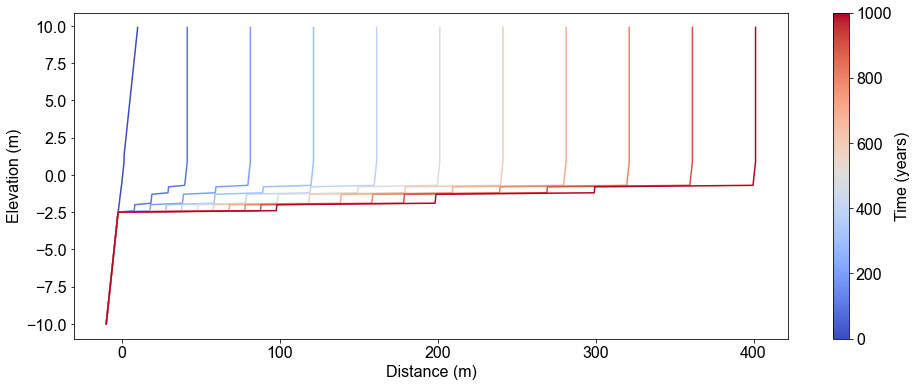

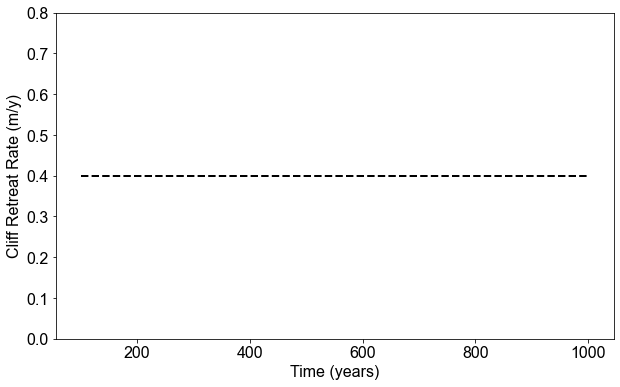

In [55]:
""" IN THIS BLOCK WE WILL CREATE A ROCK COAST MODEL OBJECT AND THEN RUN IT"""
MyRockCoast = RockCoast()
MyRockCoast.RunModel()

Now we will explore how different sea level boundary conditions influence the development of the shore platform and its resulting morphology. Note how we declare a new model instance called `MyRockCoast`, then set `MyRockCoast.SeaLevelRise` before running the model with `MyRockCoast.RunModel()`. This is how we can modify any of the default model parameters.

FloatProgress(value=0.0, max=1000.0)

C:\Users\mh322u\AppData\Local\Temp\ipykernel_12604\771560422.py:167: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


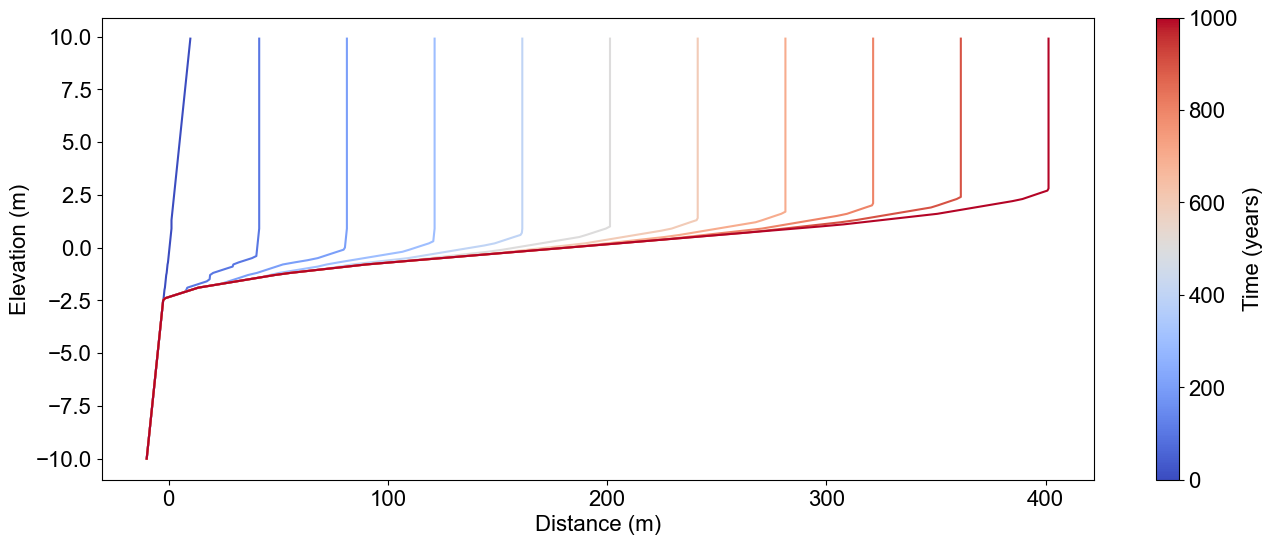

In [16]:
""" IN THIS BLOCK WE WILL CREATE A ROCK COAST MODEL OBJECT AND MODIFY SEA LEVEL THEN RUN IT"""
MyRockCoast = RockCoast()
MyRockCoast.SeaLevelRise = 0.0035 # 3.5 mm/yr
MyRockCoast.RunModel()

FloatProgress(value=0.0, max=1000.0)

C:\Users\mh322u\AppData\Local\Temp\ipykernel_12604\771560422.py:167: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


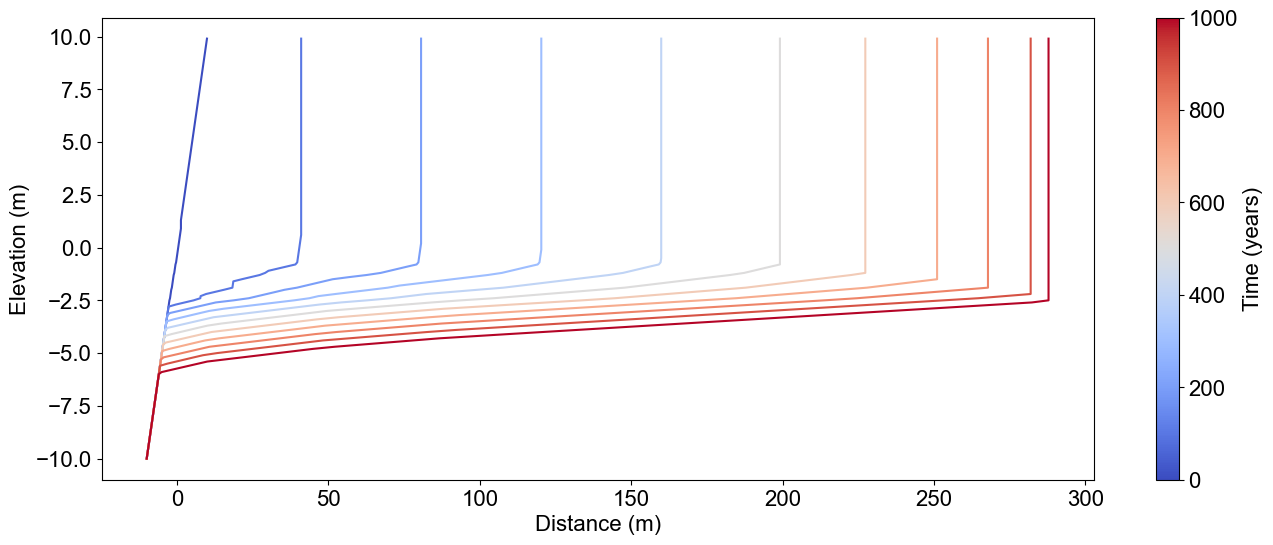

In [17]:
""" IN THIS BLOCK WE WILL CREATE A ROCK COAST MODEL OBJECT AND MODIFY SEA LEVEL AND THEN RUN IT"""
MyRockCoast = RockCoast()
MyRockCoast.SeaLevelRise = -0.0035 # 3.5 mm/yr
MyRockCoast.RunModel()

FloatProgress(value=0.0, max=1000.0)

C:\Users\mh322u\AppData\Local\Temp\ipykernel_12604\771560422.py:167: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


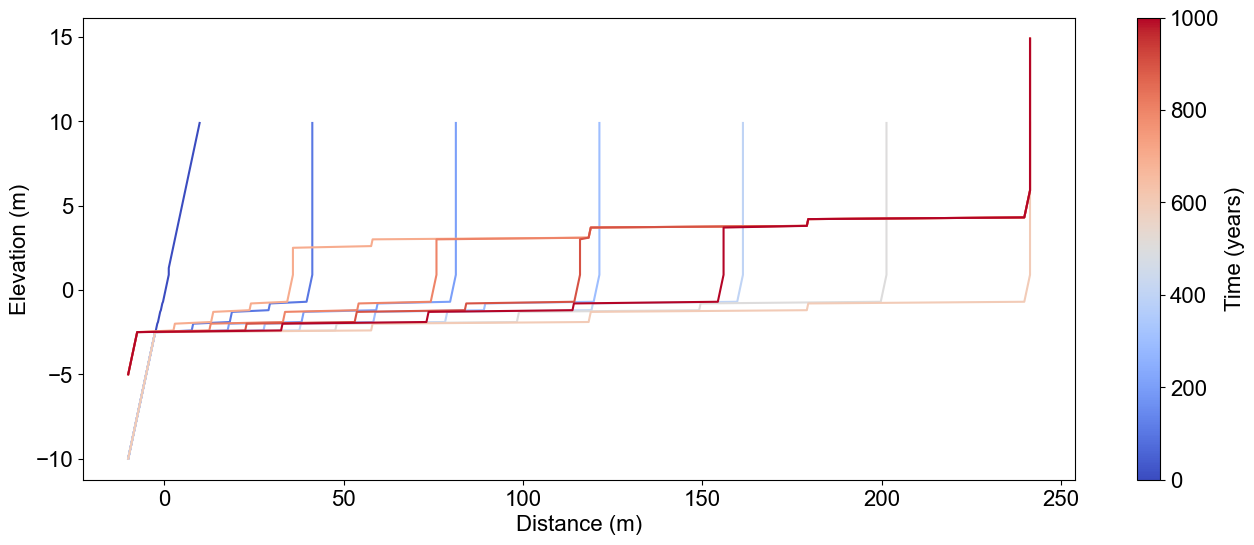

In [18]:
""" IN THIS BLOCK WE WILL CREATE A ROCK COAST MODEL OBJECT AND TURN ON EARTHQUAKES AND THEN RUN IT"""
MyRockCoast = RockCoast()
MyRockCoast.EarthquakeTime = 600 # years
MyRockCoast.EarthquakeUplift = 5.
MyRockCoast.RunModel()

<div class="alert alert-block alert-info">
<font color="black">
<h3>TASK 4</h3>
<p> Write a paragraph explaining the influence of relative sea level change on shore platform morphology and evolution. Comment on the conditions that might lead to formation of marine terraces.
</p>
<p></p>
</font>
</div>

### DOUBLE CLICK ON THIS BLOCK AND YOU CAN TYPE YOUR ANSWERS

Type your answers here once you have double-clicked.

## Explore the influence of another parameter on rock coast development

Now that you've seen how we can change model parameters, its time to start tinkering with the model yourself. ***Note that there is a very good chance that you will break the model if you change some parameters too much*** the simplified nature of this model is missing some checks and balances from the full version that stop it going off the rails. Don't worry about it! 

Below are some examples of parameters you might change. They are currently all set to their default values.

FloatProgress(value=0.0, max=1000.0)

C:\Users\mh322u\AppData\Local\Temp\ipykernel_12604\771560422.py:167: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


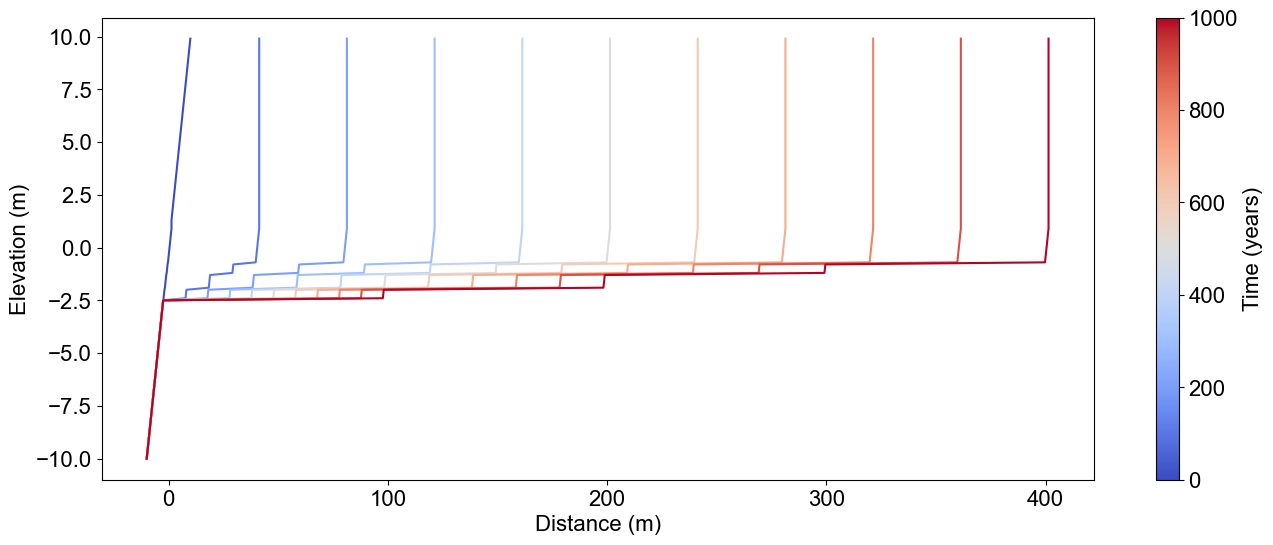

In [19]:
""" IN THIS BLOCK WE WILL CREATE A ROCK COAST MODEL OBJECT AND MODIFY SOME PARAMETERS"""
MyRockCoast = RockCoast()
MyRockCoast.InitialSlope = 1.      # gradient of the initial topography

MyRockCoast.WaveHeight = 2.        # wave height in metres
MyRockCoast.WaveForceCoef = 10.    # coefficient for efficiency of wave action
MyRockCoast.WaveDecayCoef = 0.1    # (in metres?)
MyRockCoast.TidalRange = 2.        # tidal range (metres)

MyRockCoast.MaxResistance = 2000.           # max resisting force
MyRockCoast.MaxWeatheringEfficacy = 100.    # max weathering rate (per year)
MyRockCoast.RunModel()

<div class="alert alert-block alert-info">
<font color="black">
<h1>ASSESSMENT TASK</h1>
<p>Conduct an investigation into explaining the sensitivity of the shore platform development model to variation in a parameter/boundary condition that you have chosen to modify. Conduct some model simulations, visualise and interpret the results.
    
The assessment format should be a written report (maximum of 1500 words, not including figure captions and references) that details the methods, results and interpretations of your modelling investigation. This report should include:</p>
   
<h3>Introduction</h3>
<ul>
    <li>A short literature review of approaches to modelling used.</li>
    <li>The aim and objectives of the investigation.</li>
</ul>
  
<h3>Methods</h3>
<ul>
    <li>Brief description of the model (within the word count you will not be able to describe the full model but you should summarise key characteristics and example applications).</li>
    <li>Description of the parameters/conditions that were varied and justification.</li>
</ul>
    
<h3>Results</h3>
<ul>
    <li>Graphical/tabular presentation of results, with accompanying descriptive text.</li>
    <li>Credit will be given for efficient reporting of results, i.e., not a lot of similar-looking graphs, but a smaller number of combined plots.</li>
</ul>
    
<h3>Interpretation/Discussion</h3>
<ul>
    <li>Evaluate how the simulations performed help you to:</li>
    <ul>
        <li>Understand how the model works.</li>
        <li>Use the model results to understand the physical system being modelled.</li>
    </ul>
</ul>
    
<h3>Conclusion</h3>
<ul>
    <li>Summary of your main findings.</li>
</ul>
    
<p>You should make appropriate references to academic/applied literature. Please compile your document with a sans-serif font (e.g., Calibri/Arial), font size 11, and page margins of 2 cm.</p>
    
   
</font>
</div>

### DOUBLE CLICK ON THIS BLOCK AND YOU CAN TYPE SOME NOTES
Type your answers here once you have double-clicked.

# SAVE YOUR WORK
Click on `File` -> `Download as` -> ...

I recommend saving it as ".ipynb" (the fully interactive notebook) ***AND*** ".pdf via Latex" so that you have a static record of all the work and your answers to the tasks. You could also save a static html webpage (which oyu'd be able to open anytime in any browser).